# Beijing Air Quality Forecasting Starter Notebook

In [95]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [98]:
# 1. Load Data
# --------------------
train = pd.read_csv("../Datasets/train.csv", parse_dates=["datetime"])
test = pd.read_csv("../Datasets/test.csv", parse_dates=["datetime"])
sample_submission = pd.read_csv("../Datasets/sample_submission .csv")


train = train.sort_values("datetime")
test = test.sort_values("datetime")

In [101]:

# Normalize column names to avoid case / punctuation mismatches
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

# ensure datetime parsed
if 'datetime' in train.columns:
    train['datetime'] = pd.to_datetime(train['datetime'])
if 'datetime' in test.columns:
    test['datetime'] = pd.to_datetime(test['datetime'])

# consistent target name
TARGET = 'pm2.5'

# build features excluding datetime and target (if present)
features = [col for col in train.columns if col not in ['datetime', TARGET]]

# Fill missing values on training features
train[features] = train[features].interpolate().fillna(method='bfill')

# Ensure test has the same feature columns (add missing with zeros)
test_aligned = test.copy()
for c in features:
    if c not in test_aligned.columns:
        test_aligned[c] = 0.0

# Reorder test to match training feature order
test_aligned = test_aligned[features]

# Scale features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[features])
test_scaled = scaler.transform(test_aligned)
train_featured = pd.DataFrame(train_scaled, columns=features)
test_featured = pd.DataFrame(test_scaled, columns=features)

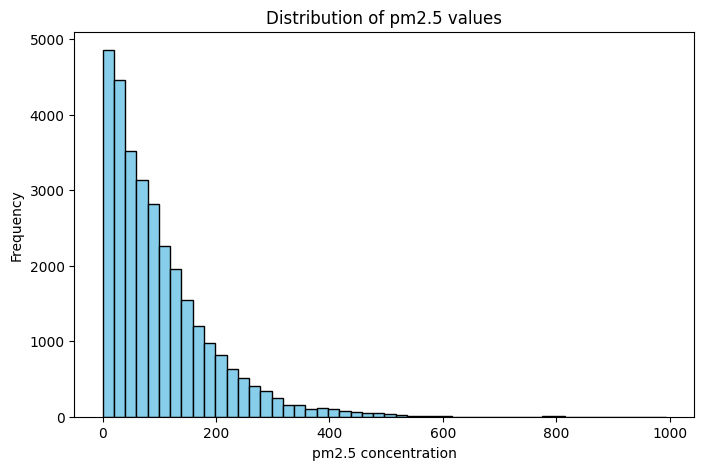

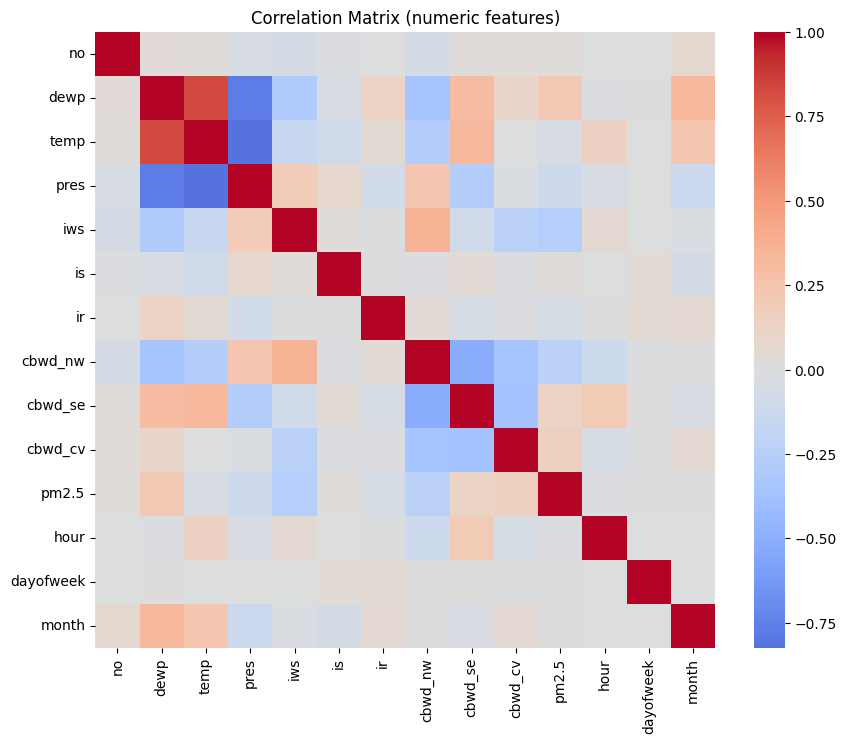

In [ ]:

# 3. EDA Before Training
# --------------------
import matplotlib.pyplot as plt
import seaborn as sns

# use TARGET defined earlier (expects 'pm2.5')
if 'TARGET' not in globals():
    TARGET = 'pm2.5'

plt.figure(figsize=(8,5))
if TARGET in train.columns:
    plt.hist(train[TARGET].dropna(), bins=50, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {TARGET} values")
    plt.xlabel(f"{TARGET} concentration")
    plt.ylabel("Frequency")
else:
    print(f"Warning: target column '{TARGET}' not found in train.columns. Available columns preview:\n{train.columns[:20].tolist()}")
plt.show()

# Correlation heatmap for numeric columns (safe)
plt.figure(figsize=(10,8))
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) == 0:
    raise RuntimeError("No numeric columns found in train for correlation heatmap.")
corr_df = train[numeric_cols].corr()
sns.heatmap(corr_df, cmap="coolwarm", annot=False, center=0)
plt.title("Correlation Matrix (numeric features)")
plt.show()

In [105]:

def create_sequences(X, y, window=24):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:(i+window)])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

In [111]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam

def build_model(window_size, n_features):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(window_size, n_features)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


Training with window size: 24


Training with window size: 48


Training with window size: 72

319/319 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step
Fold 1/3, RMSE: 0.0696
103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step
319/319 ━━━━━━━━━━━━━━━━━━━━ 48s 142ms/step
Fold 2/3, RMSE: 0.0608
103/103 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step
319/319 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step
Fold 3/3, RMSE: 0.0708
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step
Mean CV RMSE (window=72): 0.0671


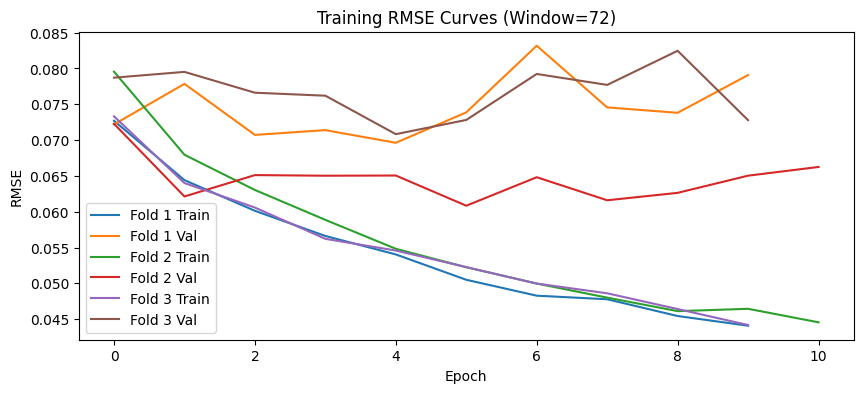

In [114]:
# 6. Rolling-Window Cross-Validation + Training with Checkpoints
for WINDOW_SIZE in window_sizes:
    print(f"\nTraining with window size: {WINDOW_SIZE}\n")

    # build target vector (use TARGET set earlier, e.g. 'pm2.5')
    if TARGET not in train.columns:
        raise KeyError(f"Target column '{TARGET}' not found in train")
    y_raw = train[TARGET].values.reshape(-1, 1)

    # scale target (keep scaler_y for inverse transforms later)
    from sklearn.preprocessing import MinMaxScaler
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y_raw).flatten()

    # create sequences (features already in train_scaled)
    X_seq, y_seq = create_sequences(train_scaled, y_scaled, WINDOW_SIZE)




# Rolling-window CV (3 folds)
import warnings

all_preds = []         # collect test predictions per fold/window
k = 3
fold_size = len(X_seq) // k
fold_rmses = []
histories = []

def make_sequences_from_scaled(X_scaled, window):
    Xs = []
    for i in range(len(X_scaled) - window):
        Xs.append(X_scaled[i:i+window])
    return np.array(Xs)

for fold in range(k):
    val_start = fold * fold_size
    val_end = (fold + 1) * fold_size

    X_train = np.concatenate([X_seq[:val_start], X_seq[val_end:]])
    y_train = np.concatenate([y_seq[:val_start], y_seq[val_end:]])
    X_val = X_seq[val_start:val_end]
    y_val = y_seq[val_start:val_end]

    model = build_model(WINDOW_SIZE, X_train.shape[2])
    checkpoint_path = f"checkpoints/best_window{WINDOW_SIZE}_fold{fold+1}.keras"
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, save_best_only=True, monitor="val_root_mean_squared_error", mode="min"
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=40,
        batch_size=32,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True), checkpoint_cb],
        verbose=0,
    )
    histories.append(history)

    # Load best model for this fold
    best_model = load_model(checkpoint_path)
    val_preds = best_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    fold_rmses.append(rmse)
    print(f"Fold {fold+1}/{k}, RMSE: {rmse:.4f}")

    # Build test sequences for this WINDOW_SIZE and predict
    if 'test_scaled' not in globals():
        raise NameError("test_scaled not found. Run feature-scaling cell before CV/prediction.")
    X_test_seq = make_sequences_from_scaled(test_scaled, WINDOW_SIZE)

    if X_test_seq.size == 0:
        warnings.warn(f"No test sequences for window={WINDOW_SIZE} (test too short). Skipping test preds for this fold.")
        test_preds = np.array([])
    else:
        preds_scaled_test = best_model.predict(X_test_seq, batch_size=128)
        if 'scaler_y' in globals():
            # scaler_y expects 2D input
            test_preds = scaler_y.inverse_transform(preds_scaled_test).flatten()
        else:
            test_preds = preds_scaled_test.flatten()

    all_preds.append(test_preds)

print(f"Mean CV RMSE (window={WINDOW_SIZE}): {np.mean(fold_rmses):.4f}")

# Plot training history (example plotting last fold histories)
plt.figure(figsize=(10,4))
for i, h in enumerate(histories):
    if 'root_mean_squared_error' in h.history:
        plt.plot(h.history['root_mean_squared_error'], label=f'Fold {i+1} Train')
    if 'val_root_mean_squared_error' in h.history:
        plt.plot(h.history['val_root_mean_squared_error'], label=f'Fold {i+1} Val')
plt.title(f"Training RMSE Curves (Window={WINDOW_SIZE})")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()


In [115]:
# 7. Ensemble Predictions
# --------------------
final_preds = np.mean(all_preds, axis=0)

In [118]:

import warnings
import numpy as np
import pandas as pd
from pathlib import Path

OUT_PATH = Path(r"c:\Users\HP\Time-Series-Forecasting\Datasets\submission.csv")

if 'final_preds' not in globals():
    raise NameError("final_preds not found. Ensure training/prediction cells ran and produced final_preds.")

sample = sample_submission.copy()

# Detect submission target column
possible_targets = ['pm2.5', 'PM2.5', 'pm25', 'target']
target_col = None
for t in possible_targets:
    if t in sample.columns:
        target_col = t
        break
if target_col is None:
    # fallback: choose last non-id numeric column
    numeric_cols = sample.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        target_col = numeric_cols[-1]
    else:
        target_col = sample.columns[-1]

print(f"Using submission target column: '{target_col}'")

preds = np.asarray(final_preds).flatten()
n_sample = len(sample)
n_preds = len(preds)
print(f"sample rows: {n_sample}, preds length: {n_preds}")

# Try to align by datetime if available
if 'test_featured' in globals() and 'datetime' in test_featured.columns and 'datetime' in sample.columns:
    pred_datetimes = test_featured['datetime'].iloc[SEQUENCE_LENGTH:SEQUENCE_LENGTH + n_preds].reset_index(drop=True)
    df_preds = pd.DataFrame({'datetime': pd.to_datetime(pred_datetimes), 'pred': preds})
    sample['datetime'] = pd.to_datetime(sample['datetime'])
    merged = sample.merge(df_preds, on='datetime', how='left')
    if merged['pred'].notna().any():
        merged[target_col] = merged['pred'].fillna(merged[target_col])
        final = merged[sample.columns]
        print("Aligned predictions by datetime merge.")
    else:
        warnings.warn("Datetime merge produced no matching rows — falling back to positional alignment.")
        final = sample.copy()
else:
    final = sample.copy()

# If still shapes mismatch, place predictions by position: last N rows (common for sequence-based preds)
if len(final) == n_sample:
    if n_preds == n_sample:
        final[target_col] = np.round(preds).clip(0, None).astype(int)
    elif n_preds < n_sample:
        pad = n_sample - n_preds
        final[target_col] = 0
        final.iloc[pad:, final.columns.get_loc(target_col)] = np.round(preds).clip(0, None).astype(int)
        warnings.warn(f"Predictions shorter than sample ({n_preds} vs {n_sample}). Placed predictions at last {n_preds} rows.")
    else:  # n_preds > n_sample
        final[target_col] = np.round(preds[-n_sample:]).clip(0, None).astype(int)
        warnings.warn(f"More predictions ({n_preds}) than sample rows ({n_sample}). Truncated to match sample length.")
else:
    raise RuntimeError("Unexpected sample shape after alignment.")

# final safety
if final.isnull().any(axis=None):
    warnings.warn("Submission contains NaNs; filling with 0.")
    final = final.fillna(0)

final.to_csv(OUT_PATH, index=False)
print(f"Saved submission to {OUT_PATH} (preds->{n_preds}, sample_rows->{n_sample})")
#

Using submission target column: 'pm2.5'
sample rows: 13148, preds length: 13076
Saved submission to c:\Users\HP\Time-Series-Forecasting\Datasets\submission.csv (preds->13076, sample_rows->13148)
